# KMeans

1)	Using Python and Numpy, write a class named KMeans with necessary methods, which implements the K-means method for clustering.

In [4]:
import numpy as np
import matplotlib.pyplot as plt
class KMeans():
    def __init__(self,k,max_iter=100):
        self.k=k
        self.max_iter=max_iter
        
    def init_center(self, X):
        n, _ = X.shape
        center = np.zeros((self.k, X.shape[1]))
        idx = np.random.choice(n)
        center[0] = X[idx]
        for i in range(1, self.k):
            D = np.min([np.linalg.norm(X - c, axis=1)**2 for c in center[:i]], axis=0)
            probs = D / np.sum(D)
            idx = np.random.choice(n, p=probs)
            center[i] = X[idx]
        return center
        
    def train(self,X,plot=False):
        losses=[]
        n,_=X.shape
        self.center=self.init_center(X)
        for _ in range (self.max_iter):
            last_center=self.center
            self.r=np.zeros([n,self.k])
            for j in range(n):
                self.cluster(self.r[j],X[j])
            self.move_center(self.r,X)
            losses.append(self.loss(X))
            print('Iteration: ',_,'loss: ', self.loss(X))
            if np.sum((last_center-self.center)**2)==0:
                break
        self.labels=np.argmax(self.r,axis=1)
        if plot:
            self.plot_cluster(X)
        iter=np.arange(len(losses))
        plt.plot(iter,losses)
        plt.xlabel('Iteration')
        plt.ylabel('Loss')
        title='Loss Curve, k= '+str(self.k)
        plt.title(title)
        plt.grid()
        plt.show()
        
        
    def distance(self,x,y):
        return np.sqrt(np.sum((x-y)**2))
    
    def cluster(self,r,x):
        dis=np.empty(self.k)
        for i in range(self.k):
            dis[i]=self.distance(x,self.center[i])
        closest_idx=np.argmin(dis)
        r[closest_idx]=1
    
    def move_center(self,r,X):
        self.center=np.dot(r.T,X)/np.sum(r,axis=0).reshape(-1,1)
        
    def plot_cluster(self, X):
        colors = ['orange', 'blue', 'green', 'red', 'purple', 'yellow', 'brown', 'pink', 'gray', 'olive'] 
        for i in range(self.k):
            plt.scatter(X[self.labels == i, 0], X[self.labels == i, 1], c=colors[i], label='Cluster {}'.format(i))
        plt.scatter(self.center[:,0], self.center[:,1], c='black', marker='x', label='Centroids')
        plt.legend()
        plt.show()
    
    def loss(self,X):
        n=X.shape[0]
        loss=0
        for i in range(n):
            for j in range(self.k):
                loss+=self.r[i,j]*self.distance(X[i],self.center[j])
        return loss

Iteration:  0 loss:  645.8902496881902
Iteration:  1 loss:  614.233714863585
Iteration:  2 loss:  614.233714863585


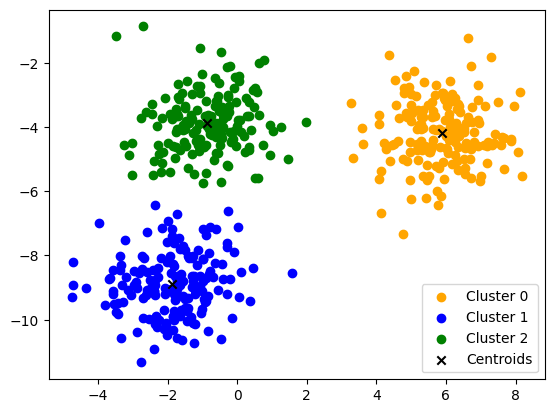

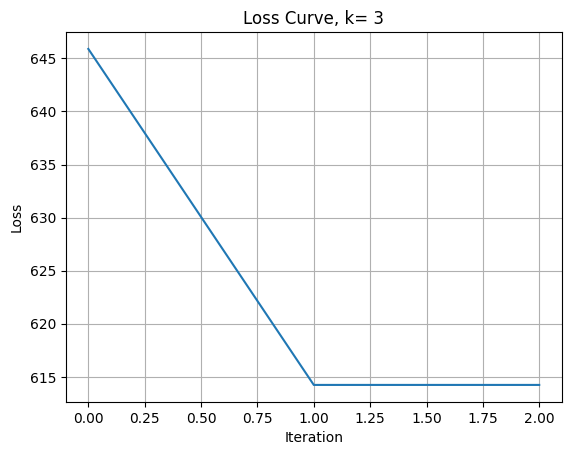

In [5]:
# Testing
from sklearn.datasets import make_blobs
X, y = make_blobs(centers=3, n_samples=500, n_features=2, shuffle=True, random_state=40)
clusters = len(np.unique(y))
k = KMeans(k=3, max_iter=150)
k.train(X,True)

Iteration:  0 loss:  377.6165190525348
Iteration:  1 loss:  330.68083276195415
Iteration:  2 loss:  316.1605016565657
Iteration:  3 loss:  314.9256613460265
Iteration:  4 loss:  314.27680675712145
Iteration:  5 loss:  313.5163438948535
Iteration:  6 loss:  313.5392543495756
Iteration:  7 loss:  313.2167999068636
Iteration:  8 loss:  313.2167999068636


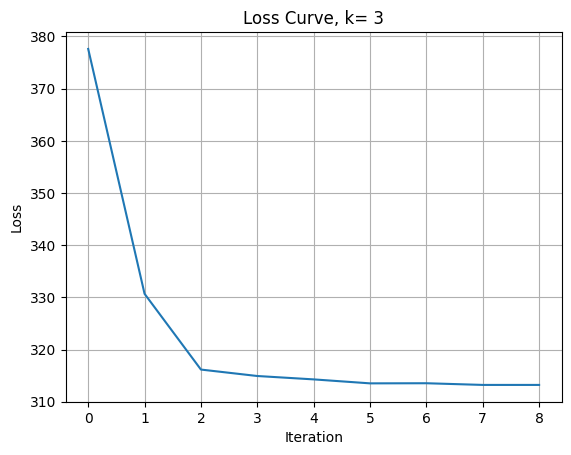

accuracy:
0.7166198557361053


In [6]:
seeds=np.loadtxt('seeds_dataset.txt')
seeds_input=seeds[:,:-1]
seeds_label=seeds[:,-1]
k=KMeans(k=3,max_iter=10)
k.train(seeds_input)
from sklearn.metrics import adjusted_rand_score
print('accuracy:')
print(adjusted_rand_score(seeds_label, k.labels))

Add non-local split-and-merge moves

Iteration:  0 loss:  307.6731384733213
Iteration:  1 loss:  318.441455561721
Iteration:  2 loss:  314.30757747615553
Iteration:  3 loss:  313.5392543495756
Iteration:  4 loss:  313.2167999068636
Iteration:  5 loss:  313.2167999068636


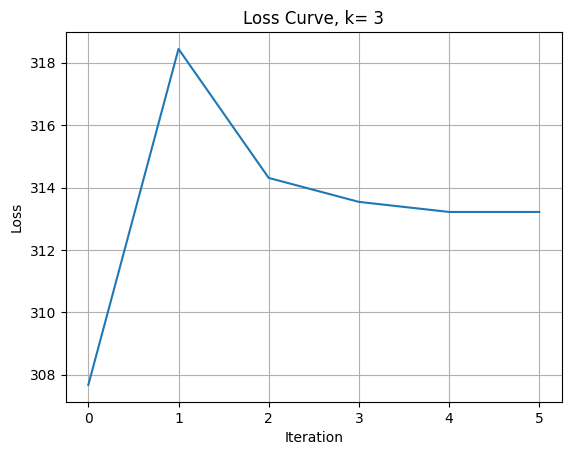

accuracy:
0.7166198557361053


In [105]:
import numpy as np
import matplotlib.pyplot as plt
# Modify the algorithm by adding non-local split-and-merge moves
class NLSM_KMeans():
    def __init__(self,k,max_iter=10,split_threshold=5,merge_threshold=2.5):
        self.k=k
        self.max_iter=max_iter
        self.split_threshold=split_threshold
        self.merge_threshold=merge_threshold
        
    def init_center(self, X, k):
        n, _ = X.shape
        center = np.zeros((k, X.shape[1]))
        idx = np.random.choice(n)
        center[0] = X[idx]
        for i in range(1, k):
            D = np.min([np.linalg.norm(X - c, axis=1)**2 for c in center[:i]], axis=0)
            probs = D / np.sum(D)
            idx = np.random.choice(n, p=probs)
            center[i] = X[idx]
        return center
    
        
    def train(self,X,plot=False):
        losses=[]
        n,_=X.shape
        self.center=self.init_center(X,self.k)
        for _ in range (self.max_iter):
            last_center=self.center
            self.r=np.zeros([n,self.k])
            for j in range(n):
                self.cluster(self.r[j],X[j])
            self.move_center(self.r,X)
            self.labels=np.argmax(self.r,axis=1)
            self.split(X)
            self.merge(X)
            losses.append(self.loss(X))
            print('Iteration: ',_,'loss: ', self.loss(X))
            if last_center.shape==self.center.shape:
                if np.sum((last_center-self.center)**2)==0:
                    break
        if plot:
            self.plot_cluster(X)
        iter=np.arange(len(losses))
        plt.plot(iter,losses)
        plt.xlabel('Iteration')
        plt.ylabel('Loss')
        title='Loss Curve, k= '+str(self.k)
        plt.title(title)
        plt.grid()
        plt.show()
        
    def split(self,X):
        n=X.shape[0]
        i=0
        while i < self.k:
            clstX=X[self.labels==i]
            sum_var=np.sum(np.var(clstX,axis=0))
            if sum_var>self.split_threshold:
                self.k+=1
                center=self.init_center(clstX,2)
                self.center=np.delete(self.center,i,axis=0)
                self.center=np.insert(self.center,i,center,axis=0)
                for _ in range(self.max_iter):
                    last_center=self.center
                    self.r=np.zeros([n,self.k])
                    for j in range(n):
                        self.cluster(self.r[j],X[j])
                    self.move_center(self.r,X)
                    self.labels=np.argmax(self.r,axis=1)
                    if np.sum((last_center-self.center)**2)==0:
                        break
                i+=1
            i+=1
    
    def merge(self,X):
        n=X.shape[0]
        i=0
        while i < self.k:
            clustX1=X[self.labels==i]
            j=i+1
            while j < self.k:
                if self.distance(self.center[i],self.center[j])<self.merge_threshold:
                    clustX2=X[self.labels==j]
                    self.k-=1
                    clustX1=np.concatenate((clustX1,clustX2),axis=0)
                    center=np.mean(clustX1,axis=0)
                    self.center=np.delete(self.center,j,axis=0)
                    self.center=np.delete(self.center,i,axis=0)
                    self.center=np.insert(self.center,i,center,axis=0)
                    for k in range(n):
                        if self.r[k,j]==1:
                            self.r[k,i]=1
                    self.r=np.delete(self.r,j,axis=1)
                    self.labels=np.argmax(self.r,axis=1)
                    j-=1
                j+=1
            i+=1
    
    
    def distance(self,x,y):
        return np.sqrt(np.sum((x-y)**2))
    
    def cluster(self,r,x):
        dis=np.empty(self.k)
        for i in range(self.k):
            dis[i]=self.distance(x,self.center[i])
        closest_idx=np.argmin(dis)
        r[closest_idx]=1
    
    def move_center(self,r,X):
        self.center=np.dot(r.T,X)/np.sum(r,axis=0).reshape(-1,1)
        
    def plot_cluster(self, X):
        colors = ['orange', 'blue', 'green', 'red', 'purple', 'yellow', 'brown', 'pink', 'gray', 'olive', 
          'cyan', 'magenta', 'lime', 'teal', 'indigo', 'beige', 'maroon', 'navy', 'gold', 'silver'] 
        for i in range(self.k):
            plt.scatter(X[self.labels == i, 0], X[self.labels == i, 1], c=colors[i], label='Cluster {}'.format(i))
        plt.scatter(self.center[:,0], self.center[:,1], c='black', marker='x', label='Centroids')
        plt.legend()
        plt.show()
    
    def loss(self,X):
        n=X.shape[0]
        loss=0
        for i in range(n):
            for j in range(self.k):
                loss+=self.r[i,j]*self.distance(X[i],self.center[j])
        return loss
# Test the NLSM_KMeans algorithm
seeds=np.loadtxt('seeds_dataset.txt')
seeds_input=seeds[:,:-1]
seeds_label=seeds[:,-1]
k=NLSM_KMeans(k=10,max_iter=11)
k.train(seeds_input)
from sklearn.metrics import adjusted_rand_score
print('accuracy:')
print(adjusted_rand_score(seeds_label, k.labels))